Exploring similarities of DVs and clustering

In [21]:
# !brew install libomp

==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
acme.sh             hypopg              redocly-cli         ubi
astroterm           icann-rdap          sdl3                umka-lang
babelfish           lazysql             sdl3_image          xeyes
behaviortree.cpp    ludusavi            terraform-cleaner   xlsclients
catgirl             martin              tf-summarize        xprop
chiko               precious            tfprovidercheck     xwininfo
==> New Casks
dana-dex                                 ik-product-manager
dockfix                                  imaging-edge-webcam
flashspace                               jottacloud
flowvision                               leader-key
font-bitcount                            linearmouse@beta
font-bitco

In [6]:
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.utils import resample
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from kneed import KneeLocator
import shap
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from hmmlearn.hmm import GaussianHMM

print(os.getcwd())
# os.chdir('../')
# print(os.getcwd())

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1


Data prep

In [7]:

df_raw = pd.read_csv('wbl_05_22_super_sabbatical_processed.csv')

df = df_raw[['groupId',
 'playerId',
 'PostDiscussionGeneral_raw_discussionDepth',
 'PostDiscussionGeneral_raw_discussionDisagreement',
 'PostDiscussionGeneral_raw_discussionEnjoy',
 'PostDiscussionGeneral_raw_discussionTension',
 'PostDiscussionGeneral_raw_selfAnxious',
 'PostDiscussionGeneral_raw_selfInsight',
 'PostDiscussionGeneral_raw_selfLearned',
 'PostDiscussionGeneral_raw_selfSpeakUp',
 'PostDiscussionGeneral_raw_selfVoice',
 'PostDiscussionPerceptionOfOthers_raw_defensive',
 'PostDiscussionPerceptionOfOthers_raw_liking',
 'PostDiscussionPerceptionOfOthers_raw_partnerListening',
 'PostDiscussionPerceptionOfOthers_raw_partnerPerspectiveTaking',
 'PostDiscussionPerceptionOfOthers_raw_partnerTalking',
 'PostDiscussionPerceptionOfOthers_raw_polite',
 'PostDiscussionPerceptionOfOthers_raw_selfPerspectiveTaking',
 'deal_sheet_agreement_binary',
 'post_negotiation_conflict_1',
 'post_negotiation_conflict_2',
 'post_negotiation_conflict_3',
 'post_negotiation_conflict_4',
 'post_negotiation_decision_leadership_1',
 'post_negotiation_decision_leadership_2',
 'post_negotiation_goal_similarity',
 'post_negotiation_viability_1',
 'post_negotiation_viability_2',
 'role']]


df.columns = ['groupId',
 'playerId',
 'discussionDepth',
 'discussionDisagreement',
 'discussionEnjoy',
 'discussionTension',
 'selfAnxious',
 'selfInsight',
 'selfLearned',
 'selfSpeakUp',
 'selfVoice',
 'defensive',
 'liking',
 'partnerListening',
 'partnerPerspectiveTaking',
 'partnerTalking',
 'polite',
 'selfPerspectiveTaking',
 'agreement_binary',
 'conflict_1',
 'conflict_2',
 'conflict_3',
 'conflict_4',
 'decision_leadership_1',
 'decision_leadership_2',
 'goal_similarity',
 'viability_1',
 'viability_2',
 'role']



df['agreement_binary'] = df['agreement_binary'].map({'Yes': 1, 'No': 0})


list(df)


/var/folders/pz/gk2tz1l92yd7r5jl_7s8l8d00000gp/T/ipykernel_5084/4086692428.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['agreement_binary'] = df['agreement_binary'].map({'Yes': 1, 'No': 0})


['groupId',
 'playerId',
 'discussionDepth',
 'discussionDisagreement',
 'discussionEnjoy',
 'discussionTension',
 'selfAnxious',
 'selfInsight',
 'selfLearned',
 'selfSpeakUp',
 'selfVoice',
 'defensive',
 'liking',
 'partnerListening',
 'partnerPerspectiveTaking',
 'partnerTalking',
 'polite',
 'selfPerspectiveTaking',
 'agreement_binary',
 'conflict_1',
 'conflict_2',
 'conflict_3',
 'conflict_4',
 'decision_leadership_1',
 'decision_leadership_2',
 'goal_similarity',
 'viability_1',
 'viability_2',
 'role']

In [8]:
def identify_principal_components(df, variables, max_components=None):
    # Drop rows with NaN values
    df = df.dropna(subset=variables)
    
    # Standardize the data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df[variables])
    
    # Perform PCA
    pca = PCA()
    pca.fit(standardized_data)
    
    # Determine the number of components to retain (explaining 95% variance or max_components)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    num_components = np.argmax(cumulative_variance >= 0.95) + 1
    if max_components:
        num_components = min(num_components, max_components)
    
    # Apply PCA with selected components
    pca = PCA(n_components=num_components)
    reduced_data = pca.fit_transform(standardized_data)
    
    # Identify variable groupings based on factor loadings
    loadings = pd.DataFrame(pca.components_.T, index=variables, columns=[f'PC{i+1}' for i in range(num_components)])
    print("PCA Factor Loadings:\n", loadings)
    
    # Display explained variance for each component and cumulative variance
    for i in range(min(3, len(explained_variance_ratio))):
        print(f"PC{i+1} explains: {explained_variance_ratio[i] * 100:.2f}%")
    print(f"Cumulative variance explained by the first {num_components} PCs: {cumulative_variance[num_components-1] * 100:.2f}%")
    
    return reduced_data, loadings, df, explained_variance_ratio, cumulative_variance




In [34]:
def perform_kmeans_clustering(reduced_data, df, variables, max_clusters=10, n_bootstrap=100, custom_colors=None, cluster_names=None):
    metrics_summary = []
    optimal_ks = []
    K = range(2, max_clusters + 1)

    # Evaluate clustering for different numbers of clusters
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(reduced_data)

        silhouette = silhouette_score(reduced_data, labels)
        davies_bouldin = davies_bouldin_score(reduced_data, labels)
        calinski_harabasz = calinski_harabasz_score(reduced_data, labels)
        distortion = np.sum(np.min(cdist(reduced_data, kmeans.cluster_centers_, 'euclidean'), axis=1))

        metrics_summary.append({
            'k': k,
            'Silhouette Score': silhouette,
            'Davies-Bouldin Index': davies_bouldin,
            'Calinski-Harabasz Index': calinski_harabasz,
            'Distortion': distortion
        })

    # Determine optimal k for each metric
    optimal_k_silhouette = max(metrics_summary, key=lambda x: x['Silhouette Score'])['k']
    optimal_k_davies_bouldin = min(metrics_summary, key=lambda x: x['Davies-Bouldin Index'])['k']
    optimal_k_calinski_harabasz = max(metrics_summary, key=lambda x: x['Calinski-Harabasz Index'])['k']
    optimal_k_distortion = min(metrics_summary, key=lambda x: x['Distortion'])['k']

    # Average the suggested k values
    optimal_k = int(np.mean([optimal_k_silhouette, optimal_k_davies_bouldin, optimal_k_calinski_harabasz, optimal_k_distortion]))
    print(f"Optimal number of clusters based on averaged metrics: {optimal_k}")

    # Final clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(reduced_data)

    # Allow user to input custom cluster names
    if cluster_names is None or len(cluster_names) != optimal_k:
        cluster_names = {i: f"Cluster {i}" for i in range(optimal_k)}
    else:
        cluster_names = {i: cluster_names[i] for i in range(optimal_k)}
    
    df['Cluster'] = [cluster_names[label] for label in clusters]

    # Cluster Stability Analysis using Bootstrapping
    ari_scores = []
    for _ in range(n_bootstrap):
        bootstrap_sample = resample(reduced_data)
        kmeans_bootstrap = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        clusters_bootstrap = kmeans_bootstrap.fit_predict(bootstrap_sample)
        ari = adjusted_rand_score(clusters, clusters_bootstrap[:len(clusters)])
        ari_scores.append(ari)
    print(f"Average Adjusted Rand Index (Cluster Stability): {np.mean(ari_scores):.2f}")

    # Feature Importance with XGBoost
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    model.fit(df[variables], clusters)

    # Cross-validation with XGBoost
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, df[variables], clusters, cv=cv)
    print(f"XGBoost Cross-Validation Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

    # Identify Top 5 Features with SHAP Scores for Each Cluster
    shap_values = shap.Explainer(model)(df[variables])

    # Handle multiclass SHAP outputs
    if len(shap_values.values.shape) == 3:
        predicted_classes = model.predict(df[variables])
        indices = np.arange(shap_values.values.shape[0])
        shap_values = shap_values.values[indices, :, predicted_classes]
    else:
        shap_values = shap_values.values

    feature_importance = pd.DataFrame(
        shap_values, columns=df[variables].columns, index=df.index  # Preserve sign of SHAP values
    )

    top_features_per_cluster = []
    for cluster_label, cluster_name in cluster_names.items():
        cluster_indices = df['Cluster'] == cluster_name
        cluster_feature_importance = feature_importance.loc[cluster_indices].mean().sort_values(ascending=False)
        top_features = cluster_feature_importance.head(5)

        # Calculate average SHAP values (with directionality)
        avg_shap_values = feature_importance.loc[cluster_indices].mean()

        top_features_per_cluster.append({
            'Cluster': cluster_name,
            'Top Features': ', '.join(top_features.index),
            'Positive SHAP Scores': ', '.join(f"{score:.3f}" for score in top_features[top_features > 0].values),
            'Negative SHAP Scores': ', '.join(f"{score:.3f}" for score in top_features[top_features < 0].values)
        })
        
    # Format cluster names for better legend display
    formatted_cluster_names = {k: v.replace(" ", "\n") for k, v in cluster_names.items()}

    # Cluster Visualization
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(reduced_data)

    plt.figure(figsize=(12, 10))

    if custom_colors is None:
        unique_clusters = df['Cluster'].unique()
        custom_colors = {cluster: color for cluster, color in zip(unique_clusters, sns.color_palette("husl", len(unique_clusters)))}

    
     # Apply custom colors if provided
    # if custom_colors is None:
    #     custom_colors = {
    #         "Open\nCollaboration": "#0000cd",
    #         "Unconstructive\nDisagreement": "#008080",
    #         "Constructive\nDisagreement": "#c71585"
    #     }
        
    scatter = sns.scatterplot(
        x=tsne_results[:, 0],
        y=tsne_results[:, 1],
        hue=df['Cluster'],
        palette=[custom_colors[cluster] for cluster in df['Cluster'].unique()],  # Apply custom color palette,  # Modern color palette
        s=100,                # Slightly smaller dots for aesthetics
        alpha=0.80,          # Slight transparency
        edgecolor='white',   # White border around points
        linewidth=0.8        # Border thickness
    )
    # plt.title('Negotiation Clusters', fontsize=20)
    plt.xlabel('t-SNE Component 1', fontsize=18)
    plt.ylabel('t-SNE Component 2', fontsize=18)
    plt.tick_params(axis='both', labelsize=18)
    plt.legend(title='', fontsize=14, loc='upper right')
    plt.grid(False)  # Remove background grid

    # Save the clustering plot
    plt.savefig('cluster_visualization.png', dpi=300)
    plt.show()

    # Display and Save Top Features Table with SHAP Scores
    top_features_df = pd.DataFrame(top_features_per_cluster)
    top_features_df.to_csv('top_features_by_cluster.csv', index=False)
    print(top_features_df)

    return df, metrics_summary, np.mean(ari_scores), np.mean(cv_scores), np.std(cv_scores), top_features_df, formatted_cluster_names

In [10]:
df = df.dropna()
df['discussionTension'] = pd.to_numeric(df['discussionTension'].replace('1S', 1))
df['discussionTension'].unique()

array([4, 3, 2, 5, 1])

In [13]:

df_num = df.drop(['role', 'groupId', 'playerId'], axis=1)

reduced_data, loadings, df_pca, explained_variance_ratio, cumulative_variance = identify_principal_components(df_num, list(df_num), max_components=50)
print(explained_variance_ratio)
print(cumulative_variance)

loadings.to_csv('./Output/Clustering/pca_loadings.csv')



PCA Factor Loadings:
                                PC1       PC2       PC3       PC4       PC5  \
discussionDepth           0.195886  0.327522 -0.119739  0.191386  0.072578   
discussionDisagreement   -0.133579  0.380583  0.037884  0.153195  0.241614   
discussionEnjoy           0.249810  0.183661 -0.104247  0.124546  0.070549   
discussionTension         0.255393 -0.086088 -0.070764  0.114850  0.036154   
selfAnxious              -0.165114  0.264533 -0.024874 -0.211033 -0.288155   
selfInsight               0.094758  0.284698 -0.261807  0.062227 -0.185464   
selfLearned              -0.072611 -0.042827 -0.057871  0.564261  0.048730   
selfSpeakUp               0.206241  0.196432 -0.043516  0.095635 -0.088511   
selfVoice                 0.105453 -0.171982 -0.202946  0.161179  0.529848   
defensive                -0.197128  0.304353 -0.177896  0.101500  0.079031   
liking                    0.268141  0.147431 -0.057698 -0.028575 -0.039280   
partnerListening          0.285595  0.0673

Optimal number of clusters based on averaged metrics: 3
Average Adjusted Rand Index (Cluster Stability): -0.00


/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740

XGBoost Cross-Validation Accuracy: 0.90 ± 0.07


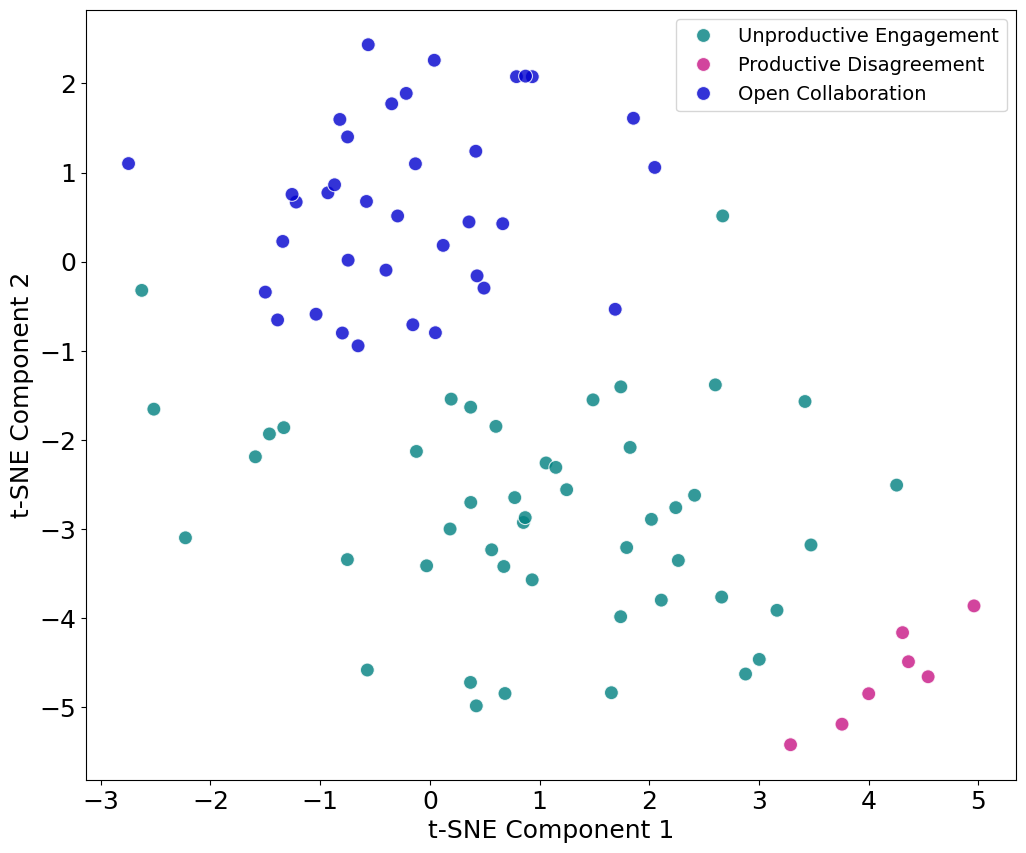

                   Cluster                                       Top Features  \
0       Open Collaboration  partnerListening, viability_1, viability_2, co...   
1  Unproductive Engagement  viability_1, selfVoice, selfAnxious, discussio...   
2  Productive Disagreement  viability_1, partnerListening, conflict_4, agr...   

                Positive SHAP Scores Negative SHAP Scores  
0  0.791, 0.411, 0.317, 0.307, 0.288                       
1  0.631, 0.348, 0.275, 0.197, 0.090                       
2  0.931, 0.862, 0.851, 0.410, 0.226                       
['partnerListening, viability_1, viability_2, conflict_3, conflict_4', 'viability_1, selfVoice, selfAnxious, discussionDisagreement, viability_2', 'viability_1, partnerListening, conflict_4, agreement_binary, discussionTension']


In [35]:
# result = perform_kmeans_clustering(reduced_data, df_pca, max_clusters=5)
cluster_names = ["Open Collaboration", "Unproductive Engagement", "Productive Disagreement"]
custom_colors = {
    "Open Collaboration": "#0000cd",
    "Unproductive Engagement": "#008080",
    "Productive Disagreement": "#c71585"
}

df, metrics_summary, ari_score, cv_score, cv_scores, top_features, formatted_cluster_names = perform_kmeans_clustering(reduced_data, df_pca, list(df_num), custom_colors=custom_colors, max_clusters=7, n_bootstrap=100, cluster_names=cluster_names)
print(list(top_features['Top Features']))
df.to_csv('Output/Clustering/cluster_labels.csv')

Segmenting conversations by conflict cluster

In [129]:
df_text = pd.read_csv('./Output/super_May22/Text_agg.csv')
list(df_text)
print(df_text.shape)
print(df.shape)

(4774, 16)
(90, 27)


In [ ]:
group_conflicts = df.copy()
group_conflicts['groupId'] = df_raw['groupId']


# Extract the last 6 characters from PairID and groupId
df_text['MergeKey'] = df_text['PairID'].str[-6:]
group_conflicts['MergeKey'] = group_conflicts['groupId'].str[-6:]

# Perform a left join
merged_data = df_text.merge(group_conflicts, on='MergeKey', how='left')

list(merged_data)

In [134]:
# Normalize the features
scaler = MinMaxScaler()
merged_data[['word_count_scaled', 'Sentiment_scaled', 'Contested_scaled']] = scaler.fit_transform(
    merged_data[['word_count', 'Sentiment', 'Contested']]
)

In [138]:
# Function to create a Left-to-Right transition matrix
def left_to_right_transition_matrix(n_states):
    """Create a Left-to-Right transition matrix for HMM."""
    transition_matrix = np.zeros((n_states, n_states))
    for i in range(n_states):
        if i < n_states - 1:
            transition_matrix[i, i] = 0.7  # Self-transition probability
            transition_matrix[i, i + 1] = 0.3  # Forward transition probability
        else:
            transition_matrix[i, i] = 1.0  # Last state stays in itself
    return transition_matrix

# Function to enforce varying number of stages using BIC
def find_optimal_hmm(features, min_states=2, max_states=5):
    best_bic = float('inf')
    best_model = None
    best_num_states = None
    for n_states in range(min_states, max_states + 1):
        try:
            # Initialize HMM with Left-to-Right constraints
            hmm_model = GaussianHMM(n_components=n_states, covariance_type="diag", random_state=42)
            hmm_model.startprob_ = np.zeros(n_states)
            hmm_model.startprob_[0] = 1.0  # Start always from the first state
            hmm_model.transmat_ = left_to_right_transition_matrix(n_states)
            hmm_model.fit(features)
            
            # Compute BIC
            n_params = (
                n_states ** 2 +  # Transition probabilities
                n_states * features.shape[1] * 2 +  # Means and variances
                n_states  # Initial probabilities
            )
            log_likelihood = hmm_model.score(features)
            bic = -2 * log_likelihood + n_params * np.log(features.shape[0])
            
            if bic < best_bic:
                best_bic = bic
                best_model = hmm_model
                best_num_states = n_states
        except Exception:
            # Ignore convergence errors
            continue
    return best_model, best_num_states

# Enforce sequential order for StageCluster
def enforce_sequential_order(df, cluster_col='StageCluster'):
    """
    Enforce sequential order for StageCluster within each conversation (PairID).
    Adjusts StageCluster so it only progresses forward or stays the same.
    """
    corrected_clusters = []
    
    for pair_id, group in df.groupby('PairID'):
        current_max = -1  # Track the maximum StageCluster seen so far
        corrected = []

        for cluster in group[cluster_col]:
            if cluster >= current_max:
                current_max = cluster  # Allow progression or staying the same
            corrected.append(current_max)  # Enforce monotonic progression
        
        corrected_clusters.extend(corrected)
    
    df[cluster_col] = corrected_clusters
    return df

In [ ]:
# Segment each conversation
stages = []
for pair_id, group in merged_data.groupby('PairID'):
    # Extract features
    features = group[['word_count_scaled', 'Sentiment_scaled', 'Contested_scaled']].values

    # Find the optimal HMM for this conversation
    hmm_model, n_states = find_optimal_hmm(features)

    if hmm_model:
        # Predict stages with the best HMM
        group['StageCluster'] = hmm_model.predict(features)

        # Map clusters to generic stage names
        group['Stage'] = group['StageCluster'].map(lambda x: f"Stage {x + 1}")
    else:
        group['StageCluster'] = -1
        group['Stage'] = "Unclassified"

    stages.append(group)

In [141]:
# Combine processed conversations
data_segmented = pd.concat(stages, ignore_index=True)

# Enforce sequential order on StageCluster
data_segmented = enforce_sequential_order(data_segmented, cluster_col='StageCluster')

# Update Stage labels based on corrected clusters
data_segmented['Stage'] = data_segmented['StageCluster'].map(lambda x: f"Stage {x + 1}")

In [143]:
# print(list(data_segmented))
# Summarize conversation stages for each conflict group
summary = (
    data_segmented.groupby(['Cluster', 'StageCluster'])
    .agg(
        avg_turns=('Turn', lambda x: len(x.unique())),  # Average count of unique turns
        std_turns=('Turn', lambda x: np.std([len(list(g)) for _, g in x.groupby(x)])),
        # avg_wordcount=('word_count', lambda x: x.sum() / len(x)),  # Average wordcount by turn
        # std_wordcount=('word_count', lambda x: np.sqrt(np.mean((x - x.sum() / len(x))**2))),
        sum_wordcount=('word_count', 'sum'),
        # std_wordcount=('word_count', 'std'),
        avg_sentiment=('Sentiment', 'mean'),
        std_sentiment=('Sentiment', 'std'),
        avg_contested=('Contested', 'mean'),
        std_contested=('Contested', 'std'),
        typical_start_time=('Start Time', 'mean'),
        typical_end_time=('End Time', 'mean')
    )
    .reset_index()
)

summary['avg_wordcount'] = summary['sum_wordcount'] / summary['avg_turns']
# summary['std_wordcount'] = np.sqrt(summary['sum_wordcount'] / summary['avg_turns'])
summary['avg_duration'] = summary['typical_end_time'] - summary['typical_start_time']

In [148]:
# Save the summary
data_segmented.to_csv("./Output/Clustering/Segmented_Conversations_With_Conflicts.csv", index=False)
summary.to_csv("./Output/Clustering/Conflict_Group_Stage_Summary.csv", index=False)